In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import datetime
import itertools
import matplotlib.dates as mdates
from scipy.optimize import curve_fit
import matplotlib.ticker as ticker
import time

In [2]:
#print(plt.style.available)
plt.style.use('seaborn-poster')

In [3]:
def get_data():
    ##Get data from the source that is used to generate map (based on WHO official data):
    ##https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html?fbclid=IwAR0oKIKJlc-zeNZGFBVEN0-O-58daoCDaKicXwC10cjFWgCZqTPgavseTfI#/bda7594740fd40299423467b48e9ecf6
    url_confirmed = "https://raw.github.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
    url_deaths = "https://raw.github.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
    url_recovered = "https://raw.github.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"        
    for url, data_type in zip([url_confirmed, url_deaths, url_recovered], ["confirmed", "deaths", "recovered"]):
    
        r = requests.get(url)
        filename=data_type+".csv"
        f = open(filename,'wb')
        f.write(r.content)

In [4]:
#get_data()

In [5]:
## prepare dataset
confirmed = pd.read_csv("confirmed_man_cor.csv")
deaths = pd.read_csv("deaths_man_cor.csv")
recovered = pd.read_csv("recovered_man_cor.csv")

#confirmed = pd.read_csv("confirmed.csv")
#deaths = pd.read_csv("deaths.csv")
#recovered = pd.read_csv("recovered.csv")



def reshape_single_dataset(data):
    data=data.drop(columns=["Province/State", "Lat", "Long"])
    ## aggregate data for each country
    data=data.groupby("Country/Region").sum().reset_index()
    ## reshape data
    data.reset_index(drop=True, inplace=True)
    data=data.set_index("Country/Region")
    #data=data.transpose().reset_index().rename(columns={'index':'Date'})
    #data['Date'] = pd.to_datetime(data['Date'])
    
    return data

confirmed = reshape_single_dataset(confirmed)
deaths = reshape_single_dataset(deaths)
recovered = reshape_single_dataset(recovered)

inactive=deaths.add(recovered)

confirmed=confirmed.transpose().reset_index().rename(columns={'index':'Date'})
confirmed['Date'] = pd.to_datetime(confirmed['Date'], errors='coerce')

inactive=inactive.transpose().reset_index().rename(columns={'index':'Date'})
inactive['Date'] = pd.to_datetime(inactive['Date'], errors='coerce')

confirmed = confirmed.dropna()
inactive = inactive.dropna()

distance = inactive.copy()

In [6]:
distance

Country/Region,Date,Poland
0,2020-01-22,0
1,2020-01-23,0
2,2020-01-24,0
3,2020-01-25,0
4,2020-01-26,0
...,...,...
197,2020-08-06,37416
198,2020-08-07,37828
199,2020-08-08,38203
200,2020-08-09,38498


In [7]:
# extract data for each country, divide by population and multiply by the value of per_num
dates=confirmed["Date"].values
dates_num = mdates.date2num(dates)
dates_start = np.min(dates_num)
dates_num = dates_num - dates_start

days_to_extrapolate=40
dates_num_extrapolate = np.arange(0,len(dates_num)+days_to_extrapolate,1)

all_countries = inactive.columns[1:]

def get_day_closest_to_value(searched, country):
    df_sort = confirmed.iloc[(confirmed[country]-searched).abs().argsort()[:1]]
    index = df_sort[country].index.values[0]
    #print(confirmed.loc[index, "Date"])
    return index


for country in all_countries:
    distance[country] = inactive[country].apply(lambda x: get_day_closest_to_value(x,country) if x > 0 else np.nan)
    


In [8]:
distance = distance.reset_index()

In [9]:
distance = distance[all_countries].sub(distance['index'], axis=0)

In [10]:
distance

Country/Region,Poland
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
197,-26.0
198,-26.0
199,-26.0
200,-26.0


In [11]:
distance = distance[all_countries].multiply(-1, axis=0)

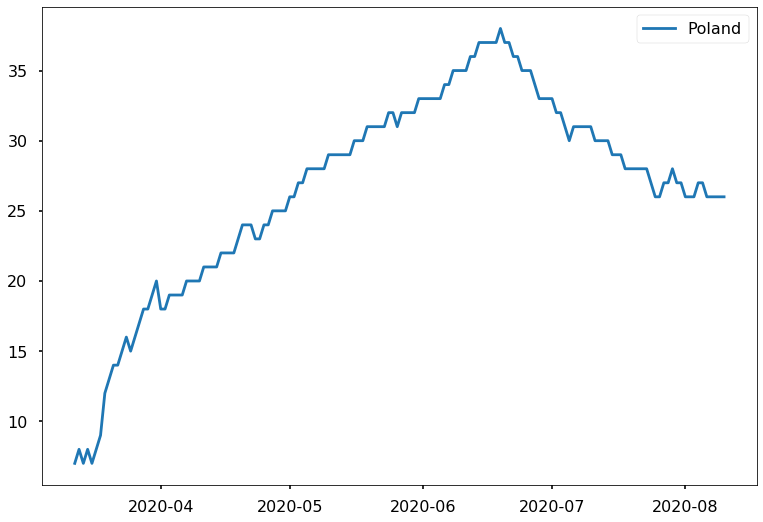

In [12]:
countries_to_plot=['Poland']

for country in countries_to_plot:
    plt.plot(dates, distance[country], label = country)
    plt. legend()

In [13]:
N=7
confirmed_derivative_ave = confirmed[all_countries].diff(periods=N)
inactive_derivative_ave = inactive[all_countries].diff(periods=N)

confirmed_derivative = confirmed[all_countries].diff(periods=1)
inactive_derivative = inactive[all_countries].diff(periods=1)


In [14]:
derivatives_ratio = confirmed_derivative.div(inactive_derivative)
derivatives_ratio_ave = confirmed_derivative_ave.div(inactive_derivative_ave)

In [15]:
inactive_derivative["Poland"]

0        NaN
1        0.0
2        0.0
3        0.0
4        0.0
       ...  
197    339.0
198    412.0
199    375.0
200    295.0
201    188.0
Name: Poland, Length: 202, dtype: float64

In [16]:
confirmed_derivative["Poland"]

0        NaN
1        0.0
2        0.0
3        0.0
4        0.0
       ...  
197    726.0
198    809.0
199    843.0
200    624.0
201    619.0
Name: Poland, Length: 202, dtype: float64

In [17]:
confirmed_derivative["Poland"].div(inactive_derivative["Poland"])

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
197    2.141593
198    1.963592
199    2.248000
200    2.115254
201    3.292553
Name: Poland, Length: 202, dtype: float64

75
56.705882352941174


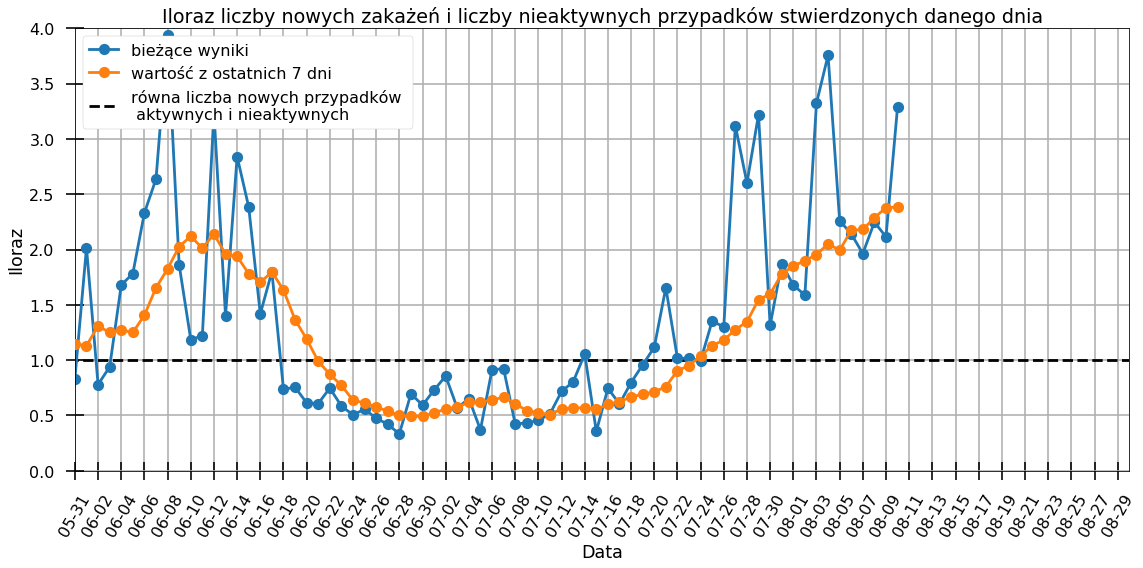

In [18]:
def exponent(x, a, b, c):
    return a * np.exp(b * (x-c))

countries_to_plot=['Poland']
rolling = derivatives_ratio.rolling(N, win_type ='triang').mean()

fig, axis = plt.subplots(1,1, figsize=(16, 8), )

x_dates = mdates.num2date(dates_num_extrapolate+dates_start)


for country in countries_to_plot:
    axis.plot(dates, derivatives_ratio[country], label = "bieżące wyniki", marker="o",)
    axis.plot(dates, derivatives_ratio_ave[country], label = "wartość z ostatnich 7 dni", marker="o", zorder=10)
    
    axis.hlines(1, x_dates[0], x_dates[-1], linestyles='--', label='równa liczba nowych przypadków \n aktywnych i nieaktywnych')
    
    y = derivatives_ratio_ave[country]
    y[y == np.inf] = 0
    
    fit_start=(np.nanargmax(y))+12
    print(fit_start)
    print(y[65])
    
    popt, pcov = curve_fit(exponent, dates_num[fit_start:], y[fit_start:], maxfev=10000)
    fit = exponent(dates_num_extrapolate[fit_start:], *popt)
    #axis.plot(mdates.num2date(dates_num_extrapolate[fit_start:]+dates_start), fit, label="dopasowanie zanik wykładniczy")
    
    fit_start=(np.nanargmax(y))+20
    0
    popt, pcov = curve_fit(exponent, dates_num[fit_start:], y[fit_start:], maxfev=10000)
    fit = exponent(dates_num_extrapolate[fit_start:], *popt)
    #axis.plot(mdates.num2date(dates_num_extrapolate[fit_start:]+dates_start), fit, label="dopasowanie zanik wykładniczy")
    
    
    
    
    tick_spacing=2
    axis.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    axis.xaxis.set_tick_params(rotation=60, direction="out")

    tick_spacing=0.5
    axis.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    date_form = DateFormatter("%m-%d")
    axis.xaxis.set_major_formatter(date_form)
    axis.tick_params(direction='inout', length=18, colors='k')  
    
    axis.grid(True)
    
    ## axes limits
    axis.set_xlim([datetime.date(2020, 5, 31),datetime.date(2020, 8, 30)])# datetime.date.today() + datetime.timedelta(days=days_to_extrapolate-12)])# datetime.date(2020, 3, 15)])
    axis.legend()
    axis.set_ylim([-0,4])
    #axis.set_yscale("log")
    legend = axis.legend(frameon=1, facecolor='white', framealpha=1, fontsize=16, handlelength=1.8, loc='upper left')

    
axis.set(xlabel="Data",
       ylabel="Iloraz",
       title="Iloraz liczby nowych zakażeń i liczby nieaktywnych przypadków stwierdzonych danego dnia")    

fig.tight_layout()
plt.show()

timestamp=time.strftime("%Y_%m_%d")
fig.savefig("./predictions_for_poland_figures/ratio_aktywne_nieaktywne_"+timestamp+".png")





In [19]:
print(derivatives_ratio[country][-25:])

177    0.604452
178    0.797647
179    0.957219
180    1.116000
181    1.655602
182    1.016043
183    1.017032
184    0.995652
185    1.354988
186    1.299120
187    3.120370
188    2.601036
189    3.220126
190    1.314103
191    1.871795
192    1.678571
193    1.588406
194    3.323699
195    3.756906
196    2.261484
197    2.141593
198    1.963592
199    2.248000
200    2.115254
201    3.292553
Name: Poland, dtype: float64


In [20]:
dates_num[fit_start:]

array([ 83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,
        94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104.,
       105., 106., 107., 108., 109., 110., 111., 112., 113., 114., 115.,
       116., 117., 118., 119., 120., 121., 122., 123., 124., 125., 126.,
       127., 128., 129., 130., 131., 132., 133., 134., 135., 136., 137.,
       138., 139., 140., 141., 142., 143., 144., 145., 146., 147., 148.,
       149., 150., 151., 152., 153., 154., 155., 156., 157., 158., 159.,
       160., 161., 162., 163., 164., 165., 166., 167., 168., 169., 170.,
       171., 172., 173., 174., 175., 176., 177., 178., 179., 180., 181.,
       182., 183., 184., 185., 186., 187., 188., 189., 190., 191., 192.,
       193., 194., 195., 196., 197., 198., 199., 200., 201.])

In [21]:
derivatives_ratio_ave["Poland"].values[-10:]

array([1.85089463, 1.89930556, 1.95434887, 2.0517158 , 1.99407205,
       2.17248062, 2.18164706, 2.2870019 , 2.37949466, 2.38350217])